Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Optimized LGBM for Each Synthetic Data

* CTGAN synthetic data got most similar feature distributions as real data
* CastGAN synthetic data got best baseline model performance

In [1]:
import pandas as pd
import numpy as np
import timeit

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
import optuna

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Load Data

In [2]:
target = 'deposit'
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/campaign_deposit.pkl')
raw_df[cat_cols] = raw_df[cat_cols].astype('category')
X_train, X_test, y_train, y_test = train_test_split(raw_df.drop(target, axis=1), raw_df[target], 
                                                    test_size=0.25, random_state=10,
                                                    stratify=raw_df[target])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

ctgan_syn_X_train = pd.read_csv('ctgan_syn_X_train_10.csv')
castgan_syn_X_train = pd.read_csv('CasTGAN/Generated_Data/wb_0/campaign_fake_20230901-2310.csv')
ctgan_syn_X_train[cat_cols] = ctgan_syn_X_train[cat_cols].astype('category')
castgan_syn_X_train[cat_cols] = castgan_syn_X_train[cat_cols].astype('category')

print(ctgan_syn_X_train.shape, castgan_syn_X_train.shape)

(8371, 16) (2791, 16) (8371,) (2791,)
(8371, 16) (8371, 16)


In [3]:
def get_opt_data(X_train, y_train, 
                 test_size=0.2, random_state=10,
                 stratify=y_train):
    opt_X_train, opt_X_val, opt_y_train, opt_y_val = train_test_split(X_train, y_train, 
                                                                      test_size=test_size,
                                                                      random_state=random_state,
                                                                      stratify=stratify)
    print(opt_X_train.shape, opt_y_train.shape, opt_X_val.shape, opt_y_val.shape)
    print(opt_y_train.value_counts()*100/opt_y_train.shape)
    print(opt_y_val.value_counts()*100/opt_y_val.shape)

    opt_X_train.reset_index(inplace=True, drop=True)
    opt_X_val.reset_index(inplace=True, drop=True)
    opt_y_train.reset_index(inplace=True, drop=True)
    opt_y_val.reset_index(inplace=True, drop=True)
    
    return opt_X_train, opt_X_val, opt_y_train, opt_y_val

In [4]:
ctgan_opt_X_train, ctgan_opt_X_val, ctgan_opt_y_train, ctgan_opt_y_val = get_opt_data(ctgan_syn_X_train, y_train, 
                                                                                      test_size=0.2,
                                                                                      random_state=10,
                                                                                      stratify=y_train)
print()

castgan_opt_X_train, castgan_opt_X_val, castgan_opt_y_train, castgan_opt_y_val = get_opt_data(castgan_syn_X_train, y_train, 
                                                                                      test_size=0.2,
                                                                                      random_state=10,
                                                                                      stratify=y_train)

(6696, 16) (6696,) (1675, 16) (1675,)
deposit
0    52.613501
1    47.386499
Name: count, dtype: float64
deposit
0    52.597015
1    47.402985
Name: count, dtype: float64

(6696, 16) (6696,) (1675, 16) (1675,)
deposit
0    52.613501
1    47.386499
Name: count, dtype: float64
deposit
0    52.597015
1    47.402985
Name: count, dtype: float64


## Tune LGBM for Each Synthetic Data

* NOTES
  * Using LGBM v4.1.0 here, comparing with LGBM v3:
    * The new version removed several parameters from `train()`, this in fact reduced confusion.
      * See detailed `train()` params: https://lightgbm.readthedocs.io/en/v4.1.0/_modules/lightgbm/engine.html
    * LGBM v4.1.0 params: https://lightgbm.readthedocs.io/en/latest/Parameters.html
  * Optuna is going to replace `trial.suggest_loguniform()` and `trial.suggest_uniform()` with `trial.suggest_float()`, this can reduce confusion too.

In [6]:
def get_hpo_params(opt_X_train, opt_X_val, opt_y_train, opt_y_val, n_trials=180, cat_features=""):
    """
    To make below optuna output reproducible, need to set hashseed in your OS: 
    https://gerrychain.readthedocs.io/en/latest/topics/reproducibility.html#set-pythonhashseed-0
    This is ot make pruning behaviour replicable.
    """
    
    def objective(trial):
        dtrain = lgb.Dataset(opt_X_train, opt_y_train, categorical_feature=cat_features)
        dval = lgb.Dataset(opt_X_val, opt_y_val, categorical_feature=cat_features)
        upper = min(32768, int(opt_X_train.shape[0]))

        params = {
            "objective": "binary",
            "metric": "average_precision",
            "random_state": 10,
            "verbosity": -1,
            "boosting": "gbdt",
            "num_threads": 4,
            "saved_feature_importance_type": 1,  # 1 means "gain", 0 means "split"

            "num_leaves": trial.suggest_int("num_leaves", 4, 50),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.5),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 10, 30),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 2500),
            "num_iterations": trial.suggest_int("num_iterations", 1000, 3000)
        }

        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "average_precision")
        clf = lgb.train(
            params, dtrain, valid_sets=[dval], callbacks=[pruning_callback]
        )

        y_val_pred = clf.predict(opt_X_val)
        avp = average_precision_score(opt_y_val, y_val_pred)
        return avp


    start = timeit.default_timer()
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.HyperbandPruner(),
                               sampler=optuna.samplers.TPESampler(seed=10), study_name='lgbm_hpo')
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))
    best_trial = study.best_trial
    print(f"Best trial performance: {best_trial.value}")
    stop = timeit.default_timer()
    print('Time (min): ', (stop - start)/60)
    
    return best_trial.params


def get_best_params(constant_params, cat_features,
                    opt_X_train, opt_X_val, opt_y_train, opt_y_val,
                    n_trials=180):
    best_params = get_hpo_params(opt_X_train, opt_X_val, opt_y_train, opt_y_val,
                                 n_trials=n_trials, cat_features=cat_features)
    best_params.update(constant_params)
    
    return best_params


def train_with_best_parames(best_params, X_train, y_train, X_test, y_test):
    opt_model = LGBMClassifier(**best_params)
    opt_model.fit(X_train, y_train)
    y_pred = opt_model.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    avp = average_precision_score(y_test, y_pred)
    
    print(f'AUC: {auc}, AVP: {avp}')
    lgb.plot_importance(opt_model)

In [10]:
constant_params = {'objective': 'binary', 'metric': 'average_precision', 'random_state': 10,
                   'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4, 'saved_feature_importance_type': 1}

ctgan_best_params = get_best_params(constant_params, cat_cols,
                    ctgan_opt_X_train, ctgan_opt_X_val, ctgan_opt_y_train, ctgan_opt_y_val,
                    n_trials=500)

castgan_best_params = get_best_params(constant_params, cat_cols,
                    castgan_opt_X_train, castgan_opt_X_val, castgan_opt_y_train, castgan_opt_y_val,
                    n_trials=500)

[I 2023-09-21 22:08:35,471] A new study created in memory with name: lgbm_hpo
[I 2023-09-21 22:08:36,227] Trial 0 finished with value: 0.4579892146033899 and parameters: {'num_leaves': 40, 'learning_rate': 0.015272214932903743, 'bagging_fraction': 0.6702834114336479, 'feature_fraction': 0.8744019412693059, 'bagging_freq': 20, 'min_data_in_leaf': 949, 'num_iterations': 1396}. Best is trial 0 with value: 0.4579892146033899.
[I 2023-09-21 22:08:37,160] Trial 1 finished with value: 0.4794633076071042 and parameters: {'num_leaves': 39, 'learning_rate': 0.08870986409845505, 'bagging_fraction': 0.17950583275660925, 'feature_fraction': 0.8426799091838986, 'bagging_freq': 30, 'min_data_in_leaf': 507, 'num_iterations': 2024}. Best is trial 1 with value: 0.4794633076071042.
[I 2023-09-21 22:08:37,192] Trial 2 pruned. Trial was pruned at iteration 1.
[I 2023-09-21 22:08:37,223] Trial 3 pruned. Trial was pruned at iteration 1.
[I 2023-09-21 22:08:38,021] Trial 4 finished with value: 0.4614104441398

Number of finished trials: 500
Best trial performance: 0.4805953182961994
Time (min):  1.684107195


[I 2023-09-21 22:10:17,844] Trial 0 finished with value: 0.4644971449408932 and parameters: {'num_leaves': 40, 'learning_rate': 0.015272214932903743, 'bagging_fraction': 0.6702834114336479, 'feature_fraction': 0.8744019412693059, 'bagging_freq': 20, 'min_data_in_leaf': 949, 'num_iterations': 1396}. Best is trial 0 with value: 0.4644971449408932.
[I 2023-09-21 22:10:19,769] Trial 1 finished with value: 0.48316172610014474 and parameters: {'num_leaves': 39, 'learning_rate': 0.08870986409845505, 'bagging_fraction': 0.17950583275660925, 'feature_fraction': 0.8426799091838986, 'bagging_freq': 30, 'min_data_in_leaf': 507, 'num_iterations': 2024}. Best is trial 1 with value: 0.48316172610014474.
[I 2023-09-21 22:10:19,831] Trial 2 pruned. Trial was pruned at iteration 1.
[I 2023-09-21 22:10:19,952] Trial 3 pruned. Trial was pruned at iteration 81.
[I 2023-09-21 22:10:21,453] Trial 4 finished with value: 0.4587556945904023 and parameters: {'num_leaves': 34, 'learning_rate': 0.3025142819352495,

Number of finished trials: 500
Best trial performance: 0.4931615809649664
Time (min):  6.977352345000001


{'num_leaves': 35, 'learning_rate': 0.04371380140818004, 'bagging_fraction': 0.6746938324598301, 'feature_fraction': 0.8077911301853921, 'bagging_freq': 24, 'min_data_in_leaf': 2235, 'num_iterations': 2731, 'objective': 'binary', 'metric': 'average_precision', 'random_state': 10, 'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4, 'saved_feature_importance_type': 1}
AUC: 0.5093462058539107, AVP: 0.4786996546331967


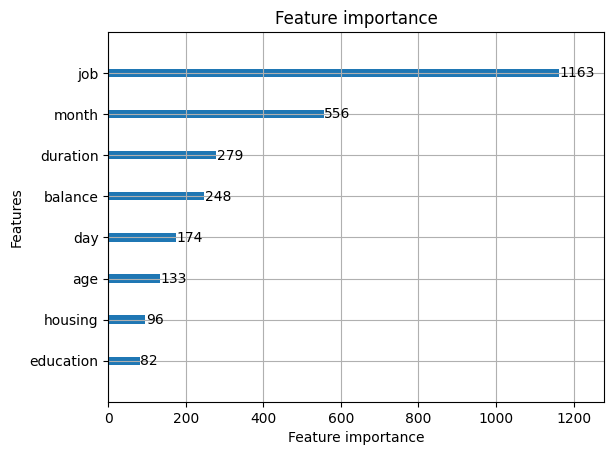

In [7]:
print(ctgan_best_params)
train_with_best_parames(ctgan_best_params, ctgan_syn_X_train, y_train, X_test, y_test)

{'num_leaves': 29, 'learning_rate': 0.30409397095587926, 'bagging_fraction': 0.3103666677735214, 'feature_fraction': 0.5751221835068885, 'bagging_freq': 16, 'min_data_in_leaf': 928, 'num_iterations': 1721, 'objective': 'binary', 'metric': 'average_precision', 'random_state': 10, 'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4, 'saved_feature_importance_type': 1}
AUC: 0.51925857535821, AVP: 0.48417347841822095


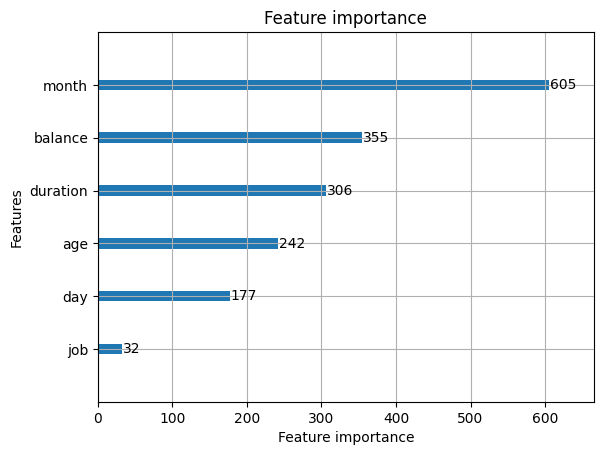

In [8]:
print(castgan_best_params)
train_with_best_parames(castgan_best_params, castgan_syn_X_train, y_train, X_test, y_test)

## Summary

* Having tried 200 ~ 2000 trials tunning, performance in testing data didn't get better than baseline model. So for LGBM, keep baseline model's parameters for later stacking.
* Baseline parameters:

`{'num_leaves': 4, 'learning_rate': 0.17937097905882862, 'bagging_fraction': 0.8506740422636537,
'feature_fraction': 0.6643670461510903, 'bagging_freq': 18, 'min_data_in_leaf': 1133,
'num_iterations': 2956, 'objective': 'binary', 'metric': 'auc', 'random_state': 10,
'verbosity': -1, 'boosting': 'gbdt', 'num_threads': 4}`